# 목적
- 데이터 분석 장인들은 이커머스 데이터를 어떻게 분석하는지 탐구. 이를 위해 캐글 노트북, 논문 등을 좀 보고 내용을 정리할 것임
- 나중에 계절성 분석, 추천 시스템, RFM 분석, 매출액 예측, 장바구니 분석 등을 할 것인데, 이를 위한 사전 작업이라 보면 됨.



# 사용  데이터셋
[Online Retail Data Set](https://www.kaggle.com/carrie1/ecommerce-data)


# 참고자료
- [Complete E-Commerce Analysis](https://www.kaggle.com/anmoltripathi/complete-e-commerce-analysis)
- [Customer Purchasing Patterns](https://www.kaggle.com/hendraherviawan/customer-purchasing-patterns)

# 목차
- Load data
- Check null
- 데이터 검증
- 성과 개선 여부 측정 ( 매출, 구매 빈도, 고객 수 )
- 구매 패턴 분석 ( 월별, 주별, 일별, 요일별, 시간별 ), ( 히트맵 사용 )

# 결과 요약
1. `StockCode`는 `ItemCode`와 `OptionCode`로 나눌 수 있다.
2. 하나의 `StockCode`는 여러 개의 `Description`과 `UnitPrice`를 가지기도 한다.
3. `Quantity`와 `UnitPrice`에 0 이하의 값이 있다.
4. 토요일과 21 - 05시에는 매출이 발생하지 않는다.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from tqdm.auto import tqdm
import calendar

# Load data

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/data/E-Commerce Data.csv', 
                 dtype={'InvoiceNo': str, 'StockCode': str, 'Description': str, 'Quantity': int, 'UnitPrice': float, 'CustomerID': str, 'Country': str}, 
                 encoding='ISO-8859-1',
                 parse_dates=['InvoiceDate'])
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  object        
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 33.1+ MB


`Quantity`와 `UnitPrice`에 음수값이 있는 것을 확인

In [ ]:
df.describe()

,Quantity,UnitPrice
count,541909.000000,541909.000000
mean,9.552250,4.611114
std,218.081158,96.759853
min,-80995.000000,-11062.060000
25%,1.000000,1.250000
50%,3.000000,2.080000
75%,10.000000,4.130000
max,80995.000000,38970.000000


In [ ]:
df.nunique().to_frame().transpose()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,25900,4070,4223,722,23260,1630,4372,38


# Check null

In [ ]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

경험상 E-commerce에서 `CustomerID`가 null인 경우는 주로 다음과 같다.
1. 비회원 주문이 가능한 경우
2. 자사 플랫폼이 아닌 오픈마켓(네이버 쇼핑, 쿠팡 등)을 통해 주문하는 경우
3. 도난, 손상 등의 이유로 물건을 판매할 수 없을 때, 재고관리 목적으로 판매 테이블에 사유와 함께 기록
4. 데이터 오류

만약 1, 2번 이유에 의해 `CustomerID`가 null이 되었다면, 분석을 통해 해당 고객들의 특성을 파악하는 것이 좋아 보인다.

In [ ]:
df_null = df[df['CustomerID'].isnull()].copy()
print(len(df_null))
df_null.head()

135080


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,2010-12-01 11:52:00,0.00,NaN,United Kingdom
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,2010-12-01 14:32:00,2.51,NaN,United Kingdom
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,2010-12-01 14:32:00,2.51,NaN,United Kingdom
1445,536544,21786,POLKADOT RAIN HAT,4,2010-12-01 14:32:00,0.85,NaN,United Kingdom
1446,536544,21787,RAIN PONCHO RETROSPOT,2,2010-12-01 14:32:00,1.66,NaN,United Kingdom


`CustomerID`가 null인 것을 제거하고 보니 `Description`이 null인 것도 같이 제거됨.

In [ ]:
df = df[~df['CustomerID'].isnull()]
df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

# 데이터 검증

## Quantity

`StockCode`가 'C'로 시작하는 것은 `Quantity`가 음수가 하며, `StockCode`가 'C'로 시작하지 않는 것은 `Quantity`가 양수여야 한다.

df는 이 조건을 만족한다.

In [ ]:
pd.DataFrame(
    index=['Quantity > 0', 'Quantity <= 0'], 
    columns=["Starts with 'C'", "Do not starts with 'C'"],
    data=[
          [len(df[(df['Quantity'] > 0) & (df['InvoiceNo'].str.startswith('C'))]), len(df[(df['Quantity'] > 0) & (~df['InvoiceNo'].str.startswith('C'))])],
          [len(df[(df['Quantity'] <= 0) & (df['InvoiceNo'].str.startswith('C'))]), len(df[(df['Quantity'] <= 0) & (~df['InvoiceNo'].str.startswith('C'))])]
          ]
    )

,Starts with 'C',Do not starts with 'C'
Quantity > 0,0,397924
Quantity <= 0,8905,0


`CustomerID`가 Null인 경우(df_null)은 이 조건을 만족하지 않는다. 즉, 'C'로 시작하지 않는데 Quantity가 음수인 것이 1,336건이 있다.

In [ ]:
pd.DataFrame(
    index=['Quantity > 0', 'Quantity <= 0'], 
    columns=["Starts with 'C'", "Do not starts with 'C'"],
    data=[
          [len(df_null[(df_null['Quantity'] > 0) & (df_null['InvoiceNo'].str.startswith('C'))]), len(df_null[(df_null['Quantity'] > 0) & (~df_null['InvoiceNo'].str.startswith('C'))])],
          [len(df_null[(df_null['Quantity'] <= 0) & (df_null['InvoiceNo'].str.startswith('C'))]), len(df_null[(df_null['Quantity'] <= 0) & (~df_null['InvoiceNo'].str.startswith('C'))])]
          ]
    )

,Starts with 'C',Do not starts with 'C'
Quantity > 0,0,133361
Quantity <= 0,383,1336


이 경우를 조금 더 분석해보자. 자주 볼 수 있는 `Description`은 다음과 같다.

In [ ]:
tmp = df_null[(df_null['Quantity'] <= 0) & (~df_null['InvoiceNo'].str.startswith('C'))]
tmp['Description'].value_counts().head(10).to_frame()

,Description
check,120
damages,45
damaged,42
?,41
sold as set on dotcom,20
Damaged,14
"Unsaleable, destroyed.",9
thrown away,9
??,7
wet damaged,5


상품이 부서지거나, 도난당하거나, 없어지면 `Quantity`를 음수로 & `CustomerID`를 null 설정하는데, 재고관리를 하기 위함으로 보인다.

## UnitPrice

`UnitPrice`가 음수인 것이 있는지 확인

In [ ]:
df[df['UnitPrice'] < 0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country


describe 함수를 통해 `UnitPrice`가 음수인 트랜잭션이 있다는 것을 확인했는데, 여기는 없다. `CustomerID`가 null인 경우에 포함될 것이라고 추측해볼 수 있다.

In [ ]:
df_null[df_null['UnitPrice'] < 0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
299983,A563186,B,Adjust bad debt,1,2011-08-12 14:51:00,-11062.06,NaN,United Kingdom
299984,A563187,B,Adjust bad debt,1,2011-08-12 14:52:00,-11062.06,NaN,United Kingdom


`UnitPrice`이 0인 상품도 있다.

`UnitPrice`이 0인 상품을 판매하는 데에는 다음과 같은 이유가 있을 수 있다.
1. '특정 상품을 몇 개 이상 구매', '특정 시즌에 얼마 이상의 돈을 쓴다'는 등 특수한 조건을 만족하여 무료로 제공
2. 데이터 오류

아래는 `UnitPrice`가 0인 트랜잭션의 목록이다. 트랜잭션의 수가 적은 것으로 보아 1번의 경우라기 보다는 2번의 이유 때문에 `UnitPrice`가 0인 것이 생긴 것으로 보인다.

In [ ]:
df[df['UnitPrice'] == 0.0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
9302,537197,22841,ROUND CAKE TIN VINTAGE GREEN,1,2010-12-05 14:02:00,0.0,12647,Germany
33576,539263,22580,ADVENT CALENDAR GINGHAM SACK,4,2010-12-16 14:36:00,0.0,16560,United Kingdom
40089,539722,22423,REGENCY CAKESTAND 3 TIER,10,2010-12-21 13:45:00,0.0,14911,EIRE
47068,540372,22090,PAPER BUNTING RETROSPOT,24,2011-01-06 16:41:00,0.0,13081,United Kingdom
47070,540372,22553,PLASTERS IN TIN SKULLS,24,2011-01-06 16:41:00,0.0,13081,United Kingdom
56674,541109,22168,ORGANISER WOOD ANTIQUE WHITE,1,2011-01-13 15:10:00,0.0,15107,United Kingdom
86789,543599,84535B,FAIRY CAKES NOTEBOOK A6 SIZE,16,2011-02-10 13:08:00,0.0,17560,United Kingdom
130188,547417,22062,CERAMIC BOWL WITH LOVE HEART DESIGN,36,2011-03-23 10:25:00,0.0,13239,United Kingdom
139453,548318,22055,MINI CAKE STAND HANGING STRAWBERY,5,2011-03-30 12:45:00,0.0,13113,United Kingdom
145208,548871,22162,HEART GARLAND RUSTIC PADDED,2,2011-04-04 14:42:00,0.0,14410,United Kingdom


가격이 0인 상품은 항상 0원에 판매되었는지 확인

In [ ]:
free_item = set(df[df['UnitPrice'] == 0.0]['StockCode'])

df[df['StockCode'].isin(free_item)].groupby('StockCode')['UnitPrice'].unique().to_frame()

,UnitPrice
StockCode,
21208,"[1.65, 1.45, 0.39, 0.0]"
21786,"[0.32, 0.42, 0.0, 0.83]"
22055,"[1.45, 1.65, 0.0, 0.39]"
22062,"[2.95, 0.83, 0.0]"
22065,"[1.45, 1.25, 0.39, 0.0]"
22089,"[2.95, 2.55, 0.0]"
22090,"[2.95, 2.55, 0.0, 5.79]"
22162,"[2.95, 0.0]"
22167,"[9.95, 3.95, 0.0]"


0원에 판매된 기록이 있는 상품이라고 항상 0원에 판매된 것은 아니었다. ( 한 번만 0원에 판매됨 )


## StockCode

### StockCode에 'POST'와 같이 문자열로 이루어진 값은 무엇인가?

In [ ]:
df_with_str = df[df['StockCode'].str.isalpha()]
df_with_str.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
45,536370,POST,POSTAGE,3,2010-12-01 08:45:00,18.00,12583,France
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527,United Kingdom
386,536403,POST,POSTAGE,1,2010-12-01 11:27:00,15.00,12791,Netherlands
1123,536527,POST,POSTAGE,1,2010-12-01 13:04:00,18.00,12662,Germany
2239,536569,M,Manual,1,2010-12-01 15:35:00,1.25,16274,United Kingdom


In [ ]:
df_with_str[['StockCode', 'Description']].drop_duplicates()

,StockCode,Description
45,POST,POSTAGE
141,D,Discount
2239,M,Manual
157195,PADS,PADS TO MATCH ALL CUSHIONS
317507,DOT,DOTCOM POSTAGE
317508,CRUK,CRUK Commission


다음과 같이 정리해볼 수 있다. ( 정확하지 않음 )
- `POSTAGE`: 우편요금
- `D`: 할인
- `M`: ?
- `PADS`: 연산 과정에서 발생하는 오차를 보정하기 위해 들어가는 값
- `DOT`: ?
- `CRUK`: ?

In [ ]:
df_with_str['StockCode'].value_counts()

POST    1196
M        465
D         77
CRUK      16
DOT       16
PADS       4
Name: StockCode, dtype: int64

상품코드가 문자열인 상품들의 가격 분포

In [ ]:
df_with_str.groupby('StockCode')['UnitPrice'].describe().transpose()

StockCode,CRUK,D,DOT,M,PADS,POST
count,16.000000,77.000000,16.000000,465.000000,4.00000,1196.000000
mean,495.839375,72.484545,744.147500,334.425634,0.00075,37.888528
std,364.164786,219.271071,540.829708,1935.070401,0.00050,334.121790
min,1.600000,0.010000,11.170000,0.000000,0.00000,1.000000
25%,284.252500,13.880000,389.082500,0.850000,0.00075,18.000000
50%,471.770000,22.970000,715.850000,3.000000,0.00100,18.000000
75%,668.977500,57.600000,998.635000,106.400000,0.00100,18.000000
max,1100.440000,1867.860000,1599.260000,38970.000000,0.00100,8142.750000


Discount를 제외한 것들은 분석하기 힘들어 보이므로 삭제

In [ ]:
df = df[(~df['StockCode'].str.isalpha()) | (df['StockCode'] == 'D')]
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


### StockCode의 마지막에 알파벳 한 글자가 붙은 것은 무엇인가?

In [ ]:
display(df[df['StockCode'] == '37444A'].head(1))
display(df[df['StockCode'] == '37444B'].head(1))
display(df[df['StockCode'] == '37444C'].head(1))

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
120,536381,37444A,YELLOW BREAKFAST CUP AND SAUCER,1,2010-12-01 09:41:00,2.95,15311,United Kingdom


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
21351,538076,37444B,BLUE BREAKFAST CUP AND SAUCER,2,2010-12-09 14:15:00,2.95,15311,United Kingdom


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
121,536381,37444C,PINK BREAKFAST CUP AND SAUCER,1,2010-12-01 09:41:00,2.95,15311,United Kingdom


상품에 대한 옵션인 것을 알 수 있다. 즉, `StockCode`는 `ItemCode`(상품 아이디)와 `OptionCode`(옵션 아이디)로 분리할 수 있다.

In [ ]:
df['ItemCode'] = df['StockCode'].map(lambda x: x[:5])
df['OptionCode'] = df['StockCode'].map(lambda x: x[5] if len(x) == 6 else '')

In [ ]:
df.groupby('ItemCode')['OptionCode'].nunique().sort_values(ascending=False)

ItemCode
90214    24
85049     8
84968     6
90036     6
84596     6
         ..
23174     1
23173     1
23172     1
23171     1
10002     1
Name: OptionCode, Length: 3211, dtype: int64

옵션이 가장 많은 `ItemCode`가 '90214'인 상품을 보자. 이 상품은 키링이며, 옵션으로 어떤 영문자를 새길지 결정할 수 있다.

In [ ]:
df[df['ItemCode'] == '90214'].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,ItemCode,OptionCode
2423,536591,90214M,"LETTER ""M"" BLING KEY RING",1,2010-12-01 16:57:00,1.25,14606,United Kingdom,90214,M
2424,536591,90214V,"LETTER ""V"" BLING KEY RING",1,2010-12-01 16:57:00,1.25,14606,United Kingdom,90214,V
2425,536591,90214S,"LETTER ""S"" BLING KEY RING",1,2010-12-01 16:57:00,1.25,14606,United Kingdom,90214,S
2426,536591,90214J,"LETTER ""J"" BLING KEY RING",2,2010-12-01 16:57:00,1.25,14606,United Kingdom,90214,J
17499,537765,90214S,"LETTER ""S"" BLING KEY RING",2,2010-12-08 12:08:00,1.25,14606,United Kingdom,90214,S


전체 상품 중 옵션이 있는 상품의 비율은 다음과 같다.

In [ ]:
round(df[df['OptionCode'] != '']['ItemCode'].nunique() / df['ItemCode'].nunique() * 100, 2)

12.8

`Description`으로부터 `ItemCode`와 `OptionCode`에 대한 정보를 추출하려 했으나 전처리할 것이 많아 생략.

실제로는 옵션이 있는 상품이지만 `StockCode`의 마지막에 알파벳을 붙이지 않은 상품도 있다. 즉, 실제 옵션이 있는 상품은 12.8%보다 많다.

## InvoiceNo
InvoiceNo에 'C'가 포함된 것은 전체 트랜잭션 중 몇 퍼센트를 차지하는가?

In [ ]:
round(len(df[df['InvoiceNo'].str.contains('C')])/len(df)*100, 2)

2.13

## 주문한 건에 대해서만 주문 취소가 가능한가?
데이터셋 구조 문제로 이 가설을 아주 정확하게 검증할 수는 없다.

정확하게 검증하기 위해서는 다음과 같은 구조를 가져야 한다.


In [ ]:
examples = [
            ('536365', False, '85123A', 'WHITE HANGING HEART T-LIGHT HOLDER', 6, '2010-12-01 08:26:00', 2.55, '17850', 'United Kingdom'),
            ('536365', True, '85123A', 'WHITE HANGING HEART T-LIGHT HOLDER', 6, '2010-12-02 08:26:00', 2.55, '17850', 'United Kingdom'),
]

pd.DataFrame(
    examples,
    columns=['InvoiceNo', 'Cancel', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'UnitPrice', 'CustomerID', 'Country']
)

,InvoiceNo,Cancel,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,False,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,True,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-02 08:26:00,2.55,17850,United Kingdom


즉, 주문 트랜잭션과 주문 취소 트랜잭션은 같은 `InvoiceNo`를 가져야 하며, 해당 트랜잭션이 취소를 위한 것인지를 표시하기 위해 `Cancel` 칼럼을 추가해야 한다.

완벽하게 검증하진 못하지만 대충이라도 해보겠다. 아래 두 가지 기준을 바탕으로 판단을 함
- 주문이 발생한 후에 주문 취소 발생
- 주문 수량이 취소 수량보다 많음

In [ ]:
def check_hypothesis_cancelled_order(df):
    failed = 0
    passed = 0
    neg_qty = df[df['Quantity'] < 0].reset_index(drop=True)
    pos_qty = df[~df['Quantity'] < 0].reset_index(drop=True)
    
    failed_negs = []

    for _, row in tqdm(neg_qty.iterrows()):
        if row['CustomerID']:
            p = pos_qty[
                        (pos_qty['CustomerID'] == row['CustomerID']) &
                        (pos_qty['StockCode'] == row['StockCode']) &
                        (pos_qty['Quantity'] >= abs(row['Quantity'])) &
                        (pos_qty['InvoiceDate'] <= row['InvoiceDate'])
            ]

            if len(p) == 0:
                failed += 1
                failed_negs.append(row.to_frame().transpose())
            else:
                passed += 1
            
    if failed > passed:
        print('Hypothesis Rejected!')
        print(f'Failed Counts: {failed} | Passed Counts: {passed}')
        print(f"Approximately {failed / (failed + passed) * 100} % rows didn't satisfy the condition")
    else:
        print('Hypothesis Accepted!')
        print(f'Failed Counts: {failed} | Passed Counts: {passed}')
        print(f"Approximately {passed / (failed + passed) * 100:.2f} % rows satisfy the condition")

    return pd.concat(failed_negs)

In [ ]:
failed_negs = check_hypothesis_cancelled_order(df)
failed_negs


Hypothesis Accepted!
Failed Counts: 1192 | Passed Counts: 7425
Approximately 86.17 % rows satisfy the condition


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,ItemCode,OptionCode
0,C536379,D,Discount,-1,2010-12-01 09:41:00,27.5,14527,United Kingdom,D,
1,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311,United Kingdom,35004,C
2,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548,United Kingdom,22556,
3,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom,21984,
4,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom,21983,
...,...,...,...,...,...,...,...,...,...,...
8520,C581100,22946,WOODEN ADVENT CALENDAR CREAM,-1,2011-12-07 11:44:00,16.95,14534,United Kingdom,22946,
8529,C581121,22526,WHEELBARROW FOR CHILDREN,-1,2011-12-07 12:28:00,12.75,14087,United Kingdom,22526,
8547,C581228,22781,GUMBALL MAGAZINE RACK,-24,2011-12-08 10:06:00,6.75,16019,United Kingdom,22781,
8565,C581305,22627,MINT KITCHEN SCALES,-1,2011-12-08 11:42:00,8.5,16933,United Kingdom,22627,


월별 트랜잭션 분포

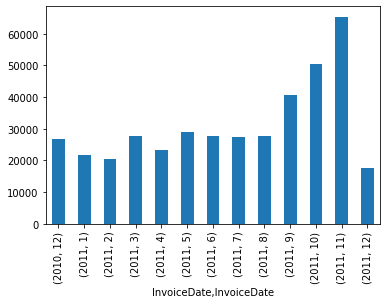

In [ ]:
df.groupby([df["InvoiceDate"].dt.year, df["InvoiceDate"].dt.month]).size().plot(kind="bar")

월별 가설 만족 못하는 트랜잭션 분포

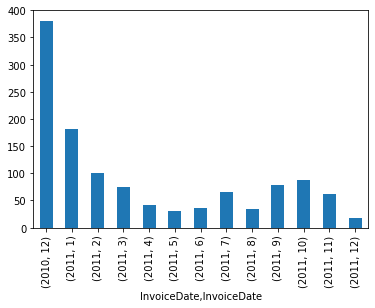

In [ ]:
failed_negs.groupby([failed_negs["InvoiceDate"].dt.year, failed_negs["InvoiceDate"].dt.month]).size().plot(kind="bar")

- 86.94 %의 트랜잭션은 주문한 것에 대해서만 취소 가능하다.
- 가설을 만족하지 못하는 것도 13% 정도 있는데, 데이터셋의 초창기에 몰려있다. 이는 2020년 12월 이전의 데이터가 없기 때문이다.

## Description
같은 상품이면 같은 Description을 가지고 있는가

In [ ]:
# no_option = df[df['OptionCode'] == ''].copy()
# no_option.head()

In [ ]:
df.groupby('StockCode').agg({'Description': ['unique', 'nunique']}).sort_values(by=('Description', 'nunique'), ascending=False).head(10)

Description        
                                                      unique nunique
StockCode                                                           
23196      [RETRO LEAVES MAGNETIC NOTEPAD, RETO LEAVES MA...       4
23236      [DOILEY STORAGE TIN, DOILEY BISCUIT TIN, STORA...       4
23370      [SET 36 COLOUR PENCILS DOILEY, SET 36 COLOURIN...       3
23209      [LUNCH BAG DOILEY PATTERN , LUNCH BAG VINTAGE ...       3
23396      [BUTTERFLY CUSHION COVER, LA JARDIN BOTANIQUE ...       3
23413      [VINTAGE COFFEE GRINDER BOX, DECROTIVEVINTAGE ...       3
22937      [BAKING MOULD CHOCOLATE CUPCAKES, BAKING MOULD...       3
17107D     [FLOWER FAIRY,5 SUMMER B'DRAW LINERS, FLOWER F...       3
22776      [SWEETHEART CAKESTAND 3 TIER, CAKESTAND, 3 TIE...       3
23126      [DOLLCRAFT GIRL AMELIE KIT, FELTCRAFT GIRL AME...       3

In [ ]:
list(df[df['StockCode'] == '23196']['Description'].unique())

['RETRO LEAVES MAGNETIC NOTEPAD',
 'RETO LEAVES MAGNETIC SHOPPING LIST',
 'LEAVES MAGNETIC  SHOPPING LIST',
 'VINTAGE LEAF MAGNETIC NOTEPAD']

In [ ]:
list(df[df['StockCode'] == '23131']['Description'].unique())

['MISTLETOE HEART WREATH CREAM',
 'MISELTOE HEART WREATH WHITE',
 'MISELTOE HEART WREATH CREAM']

In [ ]:
df.groupby('StockCode').filter(lambda x: x['Description'].nunique() >= 2)['StockCode'].nunique()

213

In [ ]:
round(df.groupby('StockCode').filter(lambda x: x['Description'].nunique() >= 2)['StockCode'].nunique() / df['StockCode'].nunique() * 100, 2)

5.79

`23131`와 같이 옵션상품임에도 옵션이 붙어있지 않은 상품이 있다.

## UnitPrice
일물일가 분석

71.68 %의 상품은 하나의 상품이 여러 개의 `UnitPrice`를 가지며, 이러한 상품의 수는 2,637개이다.



In [ ]:
round(df.groupby('StockCode').filter(lambda x: x['UnitPrice'].nunique() >= 2)['StockCode'].nunique() / df['StockCode'].nunique() * 100, 2)

71.68

In [ ]:
df.groupby('StockCode').filter(lambda x: x['UnitPrice'].nunique() >= 2)['StockCode'].nunique()

2637

가장 비싸게 팔렸을 때와 싸게 팔렸을 때의 차이가 큰 것은 어떤 상품일까일까?

In [ ]:
price_difference = df.groupby('StockCode', as_index=False).agg({'UnitPrice': ['min', 'max']})
price_difference = price_difference[price_difference[('UnitPrice', 'min')] != 0]
price_difference.columns = ["".join(a) for a in price_difference.columns.to_flat_index()]
price_difference['diff_ratio'] = price_difference['UnitPricemax'] / price_difference['UnitPricemin']
price_difference = price_difference.sort_values(by='diff_ratio', ascending=False)
price_difference = pd.merge(price_difference, df[['StockCode', 'Description']].drop_duplicates(subset=['StockCode']), how='left', on='StockCode')
price_difference.head(10)

,StockCode,UnitPricemin,UnitPricemax,diff_ratio,Description
0,D,0.010,1867.86,186786.000000,Discount
1,BANK CHARGES,0.001,15.00,15000.000000,Bank Charges
2,17003,0.160,57.60,360.000000,BROCADE RING PURSE
3,22502,2.000,649.50,324.750000,PICNIC BASKET WICKER SMALL
4,84347,0.030,4.96,165.333333,ROTATING SILVER ANGELS T-LIGHT HLDR
5,40016,0.250,8.29,33.160000,CHINESE DRAGON PAPER LANTERNS
6,22627,0.760,16.63,21.881579,MINT KITCHEN SCALES
7,85036C,0.500,8.29,16.580000,ROSE 1 WICK MORRIS BOXED CANDLE
8,22940,0.500,8.29,16.580000,FELTCRAFT CHRISTMAS FAIRY
9,22138,0.700,10.79,15.414286,BAKING SET 9 PIECE RETROSPOT


다른 상품들과 구분되는 특징을 찾을 수 없다.

# 성과 개선 여부 측정 ( 매출, 구매 빈도, 고객 수 )
- 성과를 측정할 때는 주문 취소 트랜잭션은 제외

In [ ]:
df = df[~(df['InvoiceNo'].str.contains('C'))]
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,ItemCode,OptionCode,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,85123,A,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,71053,,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,84406,B,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,84029,G,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,84029,E,20.34


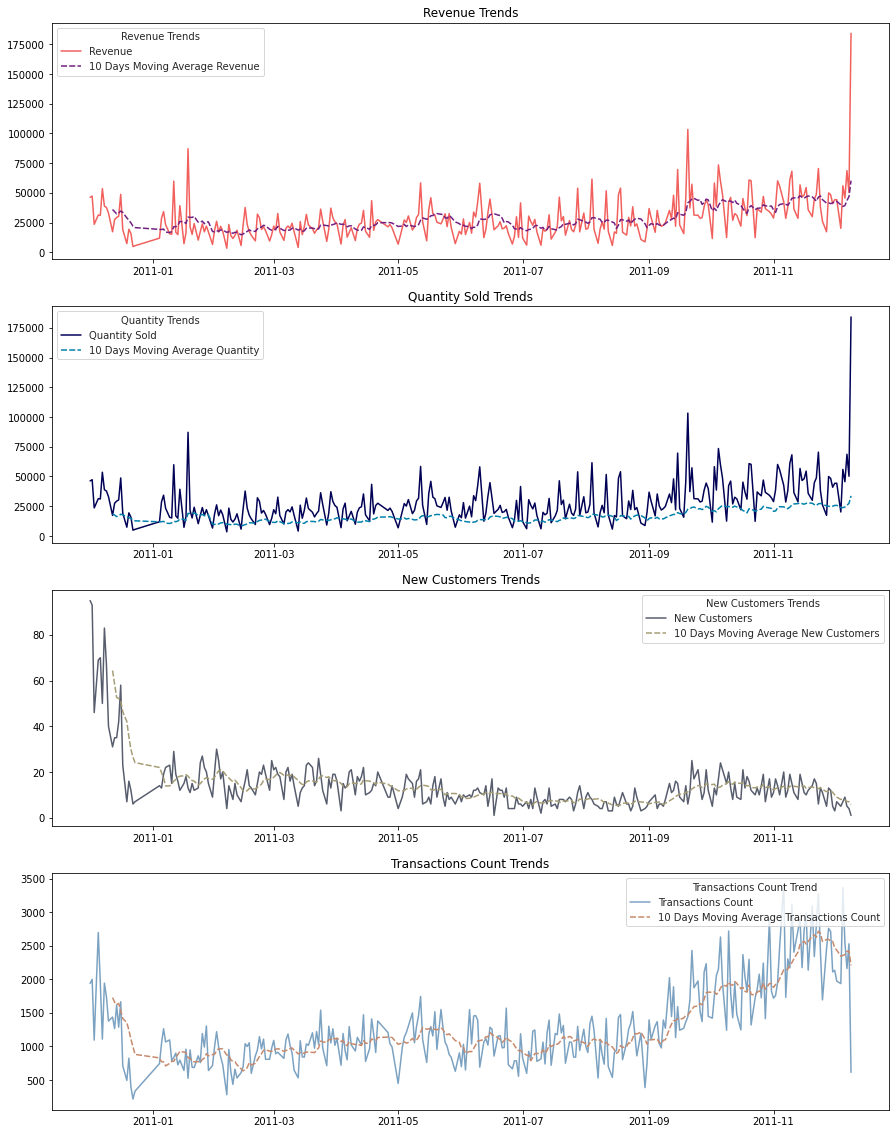

In [ ]:
fig, ax = plt.subplots(nrows=4, ncols=1,figsize=(15,20))

rev = df[df['TotalPrice']>=0]
rev['TransactionsCount'] = 1
rev = rev.groupby(rev['InvoiceDate'].dt.date).agg({'TotalPrice':'sum',
                                                  'Quantity': 'sum',
                                                  'CustomerID': 'count',
                                                  'TransactionsCount':'sum'})
rev['10 Days Moving Average Revenue'] = rev['TotalPrice'].rolling(10).mean()
rev['10 Days Moving Average Quantity'] = rev['Quantity'].rolling(10).mean()
rev['10 Days Moving Transactions Count'] = rev['TransactionsCount'].rolling(10).mean()

cust = df.groupby('CustomerID').first().reset_index()[['CustomerID','InvoiceDate']]
cust = cust.groupby(cust.InvoiceDate.dt.date).agg({'CustomerID':'count'})
cust['10 Days Moving Average Quantity'] = cust['CustomerID'].rolling(10).mean()

sns.set_style("whitegrid")
sns.lineplot(data=rev[['TotalPrice','10 Days Moving Average Revenue']], palette='magma_r', linewidth=1.5, ax=ax[0],legend=False)
ax[0].legend(title='Revenue Trends', loc='upper left', labels=['Revenue', '10 Days Moving Average Revenue'])
ax[0].title.set_text('Revenue Trends')
ax[0].set_xlabel('')

sns.lineplot(data=rev[['TotalPrice','10 Days Moving Average Quantity']], palette='ocean', linewidth=1.5, ax=ax[1])
ax[1].legend(title='Quantity Trends', loc='upper left', labels=['Quantity Sold', '10 Days Moving Average Quantity'])
ax[1].title.set_text('Quantity Sold Trends')
ax[1].set_xlabel('')

sns.lineplot(data=cust, palette='cividis', linewidth=1.5, ax=ax[2])
ax[2].legend(title='New Customers Trends', loc='upper right', labels=['New Customers', '10 Days Moving Average New Customers'])
ax[2].title.set_text('New Customers Trends')
ax[2].set_xlabel('')

sns.lineplot(data=rev[['TransactionsCount','10 Days Moving Transactions Count']], palette='twilight_shifted', linewidth=1.5, ax=ax[3])
ax[3].legend(title='Transactions Count Trend', loc='upper right', labels=['Transactions Count', '10 Days Moving Average Transactions Count'])
ax[3].title.set_text('Transactions Count Trends')
ax[3].set_xlabel('')

plt.show()

# 구매 패턴 분석 ( 월별, 일별, 요일별, 시간별 ), ( 히트맵 사용 )

## 월별 매출
- 연말에 성과가 좋아진다.
- 신규고객의 유입이 줄어들다가 12월에 튀는 경향이 있다.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


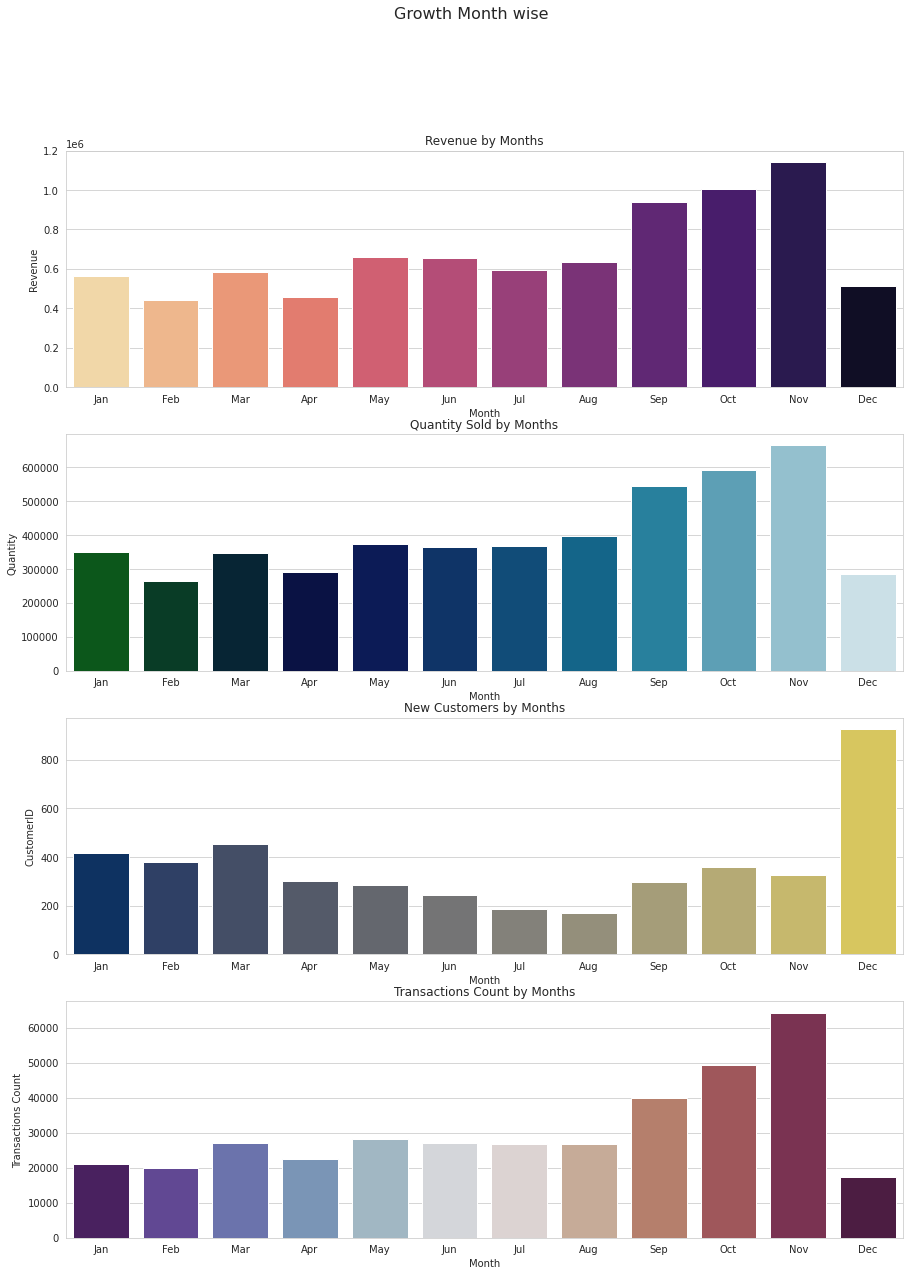

In [ ]:
fig, ax = plt.subplots(nrows=4, ncols=1,figsize=(15,20))
rev = df[(df['TotalPrice']>0)&(df['InvoiceDate'].dt.year==2011)]
rev['Transactions Count'] = 1
rev = rev.groupby(rev['InvoiceDate'].dt.month).agg({'TotalPrice':'sum',
                                                  'Quantity': 'sum',
                                                  'CustomerID': 'count',
                                                'Transactions Count':'sum'})
rev = rev.reset_index()
rev['Month'] = rev['InvoiceDate'].apply(lambda x: calendar.month_abbr[x])
rev = rev.rename({'TotalPrice':'Revenue'},axis=1)
cust = df.groupby('CustomerID').first().reset_index()[['CustomerID','InvoiceDate']]
cust = cust.groupby(cust.InvoiceDate.dt.month).agg({'CustomerID':'count'})
cust = cust.reset_index()
cust['Month'] = cust['InvoiceDate'].apply(lambda x: calendar.month_abbr[x])

sns.set_style("whitegrid")
sns.barplot(data=rev, x=rev.Month, y='Revenue', palette='magma_r', ax=ax[0])
ax[0].title.set_text('Revenue by Months')

sns.barplot(data=rev, x=rev.Month, y='Quantity',  palette='ocean', ax=ax[1])
ax[1].title.set_text('Quantity Sold by Months')

sns.barplot(data=cust, x=cust.Month, y='CustomerID',  palette='cividis', ax=ax[2])
ax[2].title.set_text('New Customers by Months')
fig.suptitle('Growth Month wise',fontsize=16)

sns.barplot(data=rev, x=rev.Month, y='Transactions Count',  palette='twilight_shifted', ax=ax[3])
ax[3].title.set_text('Transactions Count by Months')
fig.suptitle('Growth Month wise',fontsize=16)

plt.show()

## 일별 매출

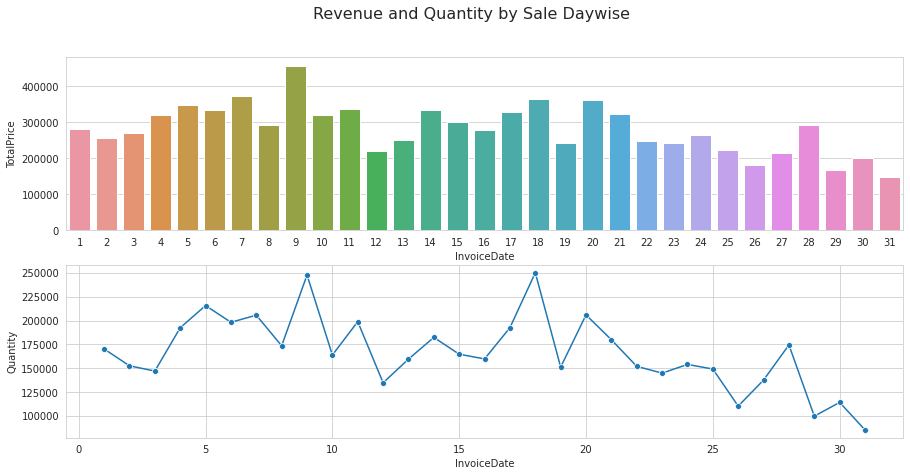

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=1,figsize=(15,7))
sns.set_style("whitegrid")

date = df[df['TotalPrice']>=0][['InvoiceDate','TotalPrice','Quantity']]
date = date.groupby(date['InvoiceDate'].dt.day)[['TotalPrice','Quantity']].sum()

sns.barplot(data = date, x=date.index, y='TotalPrice', alpha=1, ax=ax[0])
sns.lineplot(data = date, x=date.index, y='Quantity', marker='o', sort = False, ax=ax[1])
fig.suptitle('Revenue and Quantity by Sale Daywise',fontsize=16)

plt.show()

## 요일별 매출
- 목요일의 매출이 가장 높다.
- 토요일은 매출이 없는 것으로 보아 장사를 안하는 날이라는 것을 알 수 있다.

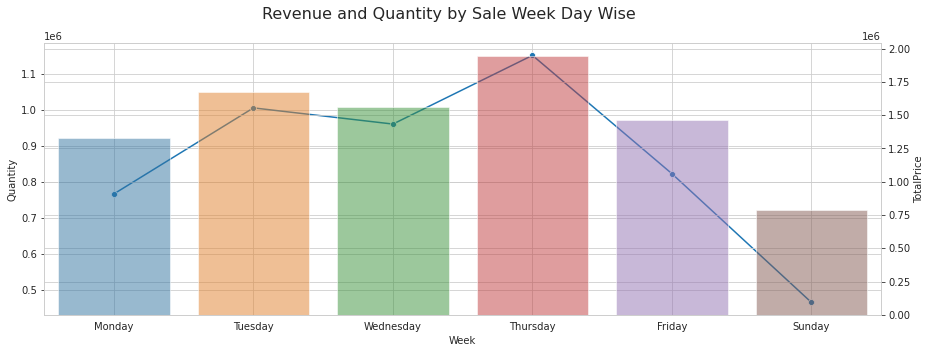

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(15,5))
sns.set_style("whitegrid")

week = df[df['TotalPrice']>=0][['InvoiceDate','TotalPrice','Quantity']]
week = week.groupby(week['InvoiceDate'].dt.weekday)[['TotalPrice','Quantity']].sum()
week = week.reset_index()
week['Week'] = week['InvoiceDate'].apply(lambda x: calendar.day_name[x])

sns.lineplot(data = week, x=week.Week, y='Quantity', marker='o', sort = False, ax=ax)
ax2 = ax.twinx()
sns.barplot(data = week, x=week.Week, y='TotalPrice', alpha=0.5, ax=ax2)
fig.suptitle('Revenue and Quantity by Sale Week Day Wise',fontsize=16)

plt.show()

## 시간별 매출
- 10 - 15시 사이에서 매출이 많이 발생한다.
- 21 - 05시는 없는 것으로 보아 그 시간에는 장사를 안하는 거나 데이터셋을 가공하는 과정에서 해당 시간대의 데이터를 삭제했을 수도 있다.

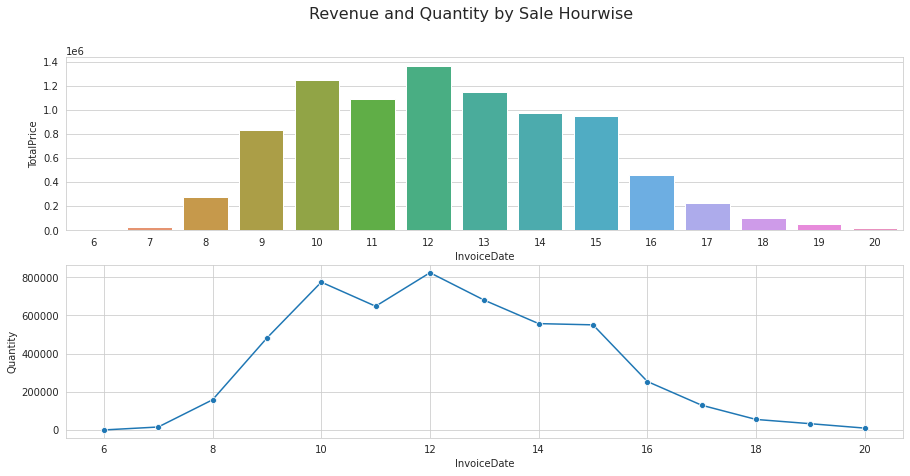

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=1,figsize=(15,7))
sns.set_style("whitegrid")

day = df[df['TotalPrice']>=0][['InvoiceDate','TotalPrice','Quantity']]
day = day.groupby(day['InvoiceDate'].dt.hour)[['TotalPrice','Quantity']].sum()

sns.barplot(data = day, x=day.index, y='TotalPrice', alpha=1, ax=ax[0])
sns.lineplot(data = day, x=day.index, y='Quantity', marker='o', sort = False, ax=ax[1])
fig.suptitle('Revenue and Quantity by Sale Hourwise',fontsize=16)
plt.show()

주문은 주로 10시에서 15시 사이에 발생하고, 12시 즈음에 가장 많이 발생한다.

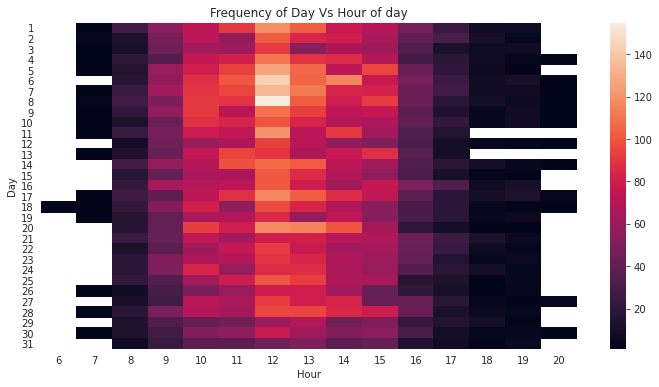

In [ ]:
tmp = df.copy()
tmp['Day'] = tmp['InvoiceDate'].dt.day
tmp['Hour'] = tmp['InvoiceDate'].dt.hour

grouped_df  = tmp.groupby([tmp['Day'], tmp['Hour']], as_index=False)["InvoiceNo"].nunique()
grouped_df = grouped_df.pivot('Day', 'Hour', 'InvoiceNo')

plt.figure(figsize=(12,6))
sns.heatmap(grouped_df)
plt.title("Frequency of Day Vs Hour of day")
plt.show()